# Overview

This notebook is used to test the imported model fine-tuned to play chess in the "llama-3.1-8b-jumpstart-chess-finetuning". Stockfish will be used to validate moves & keep track of the board. Stockfish will also be the opponent that the LLM will play against. Learn more about Stockfish [here](https://stockfishchess.org/)    

Install dependencies 

In [1]:
!pip install chess stockfish --upgrade --quiet

Set up Bedrock client and set your import model's ARN as the model id

In [2]:
import boto3
import json
from botocore.exceptions import ClientError

br_run_client = boto3.client("bedrock-runtime", region_name="us-east-1")

#ENTER YOUR IMPORTED MODEL ARN HERE
#br_model_id = "YOU-IMPORT-MODEL-ARN"
br_model_id = "arn:aws:bedrock:us-east-1:874604298668:imported-model/cea6h6w8sakz"

Initialize prompt template

In [3]:
template = {
    "prompt": (
        "<s>[INST] You are a chess engine. Given a chess position in FEN notation and the color to move, "
        "provide the next best valid move in SAN (Standard Algebraic Notation) format to progress towards winning the game of chess. "
        "Your response must be a single move wrapped in <move></move> tags.\n\n"
        "Chess Position (FEN): {fen}\n"
        "Color to Move: {nxt_color} [/INST]"
    ),
    "completion": " <move>{move}</move> </s>"
}

Create function to invoke model and print the result

In [5]:
def call_invoke_model_and_print(native_request):
    request = json.dumps(native_request)

    try:
        # Invoke the model with the request.
        response = br_run_client.invoke_model(modelId=br_model_id, body=request)
        model_response = json.loads(response["body"].read())
        #print(f"model_response: {model_response}")
        response_text = model_response['generation'].replace("\n", "")
        return response_text
    except (ClientError, Exception) as e:
        print(f"ERROR: Can't invoke '{br_model_id}'. Reason: {e}")
        exit(1)

The move from the LLM comes in between some XML tags, the function below will let us dynamically pull out just the move in SAN notation.

In [6]:
from bs4 import BeautifulSoup

def extract_by_tag(response: str, tag: str, extract_all=False) -> str | list[str] | None:
    soup = BeautifulSoup(response)
    results = soup.find_all(tag)
    if not results:
        return
        
    texts = [res.get_text() for res in results]
    if extract_all:
        return texts
    return texts[-1]

Encapsulated function to get the next move from the LLM 

In [22]:
def get_llm_next_move(fen_context, next_turn, illegal_move):

    instruction = '''In the FEN Lowercase letters describe the black pieces. "p" stands for pawn, "r" for rook, "n" for knight, "b" for bishop, "q" for queen, and "k" for king.
The same letters are used for the white pieces, but they appear in uppercase.
Empty squares are denoted by numbers from one to eight, depending on how many empty squares are between two pieces.
Use the FEN to understand the position of the pieces on the chessboard and recommend legal moves accordingly and follow the rules of playing chess to recommend legal moves.'''

    context = f"You are a chess grandmaster. You are playing {next_turn} color and the current chessboard FEN is {fen_context}."

    #formatted_prompt = template["prompt"].format(instruction=instruction, context=context, answer="")
    # Format the prompt using the template
    formatted_prompt = instruction + context + template["prompt"].format(
        fen=fen_context,
        nxt_color=next_turn
    )

    # if illegal_move is not None and len(illegal_move) > 0:
    #     formatted_prompt = f"{formatted_prompt} {illegal_move} is not a valid move."

    #print(f"formatted_prompt: {formatted_prompt}")
    native_request = {
        "prompt": formatted_prompt,
        "max_tokens": 15,
        "top_p": 0.9,
        "temperature": 1.0,
        "top_k": 50,
    }
    #Get LLM output
    llm_output = call_invoke_model_and_print(native_request) 
    llm_output = extract_by_tag(llm_output, "move")
    return llm_output

Get the next move, by passing in the board state + the player who's turn it is

In [25]:
#get_llm_next_move("rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1", "WHITE", None)
llm_move = get_llm_next_move("6k1/4qpb1/1p2p1p1/p1n4p/P1P2P2/1P3BP1/5BKP/3Q4 w - - 6 44", "WHITE", None)
print(llm_move)

Nb6


Setup Stockfish board

In [26]:
!chmod 777 stockfish/stockfish-ubuntu-x86-64-sse41-popcnt

In [27]:
#Set up Stockfish
from stockfish import Stockfish
import chess
import chess.engine

stockfish = Stockfish(path="stockfish/stockfish-ubuntu-x86-64-sse41-popcnt")

In [28]:
#stockfish.update_engine_parameters({"Hash": 2048, "UCI_Chess960": "true"})
stockfish.set_elo_rating(1350)
fen_state = stockfish.get_fen_position()

board = chess.Board()
board.reset_board()
board.chess960 = True
stockfish.set_fen_position(board.fen())

move_count = 0
move_list = []
s = ","

SF Move  - c2c4 | WHITE | Is Move Legal: True | FEN: rnbqkb1r/pppppppp/5n2/8/2PP4/8/PP2PPPP/RNBQKBNR b KQkq - 0 2 | Move Count: 3
Failed to get a move from LLM. Ending the game.


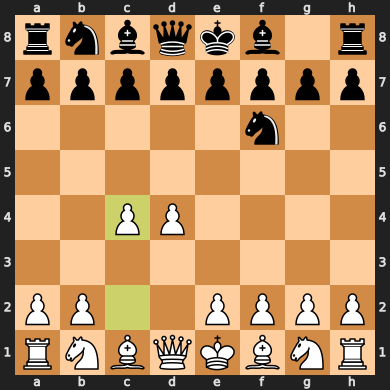

In [31]:
while True:

    sfish_move = stockfish.get_best_move()
    try:
        move_color = 'WHITE' if board.turn else 'BLACK'
        uci_move = board.push_san(sfish_move).uci()
        stockfish.set_fen_position(board.fen())
        move_count += 1
        move_list.append(f"{sfish_move}")
        print(f'SF Move  - {sfish_move} | {move_color} | Is Move Legal: {stockfish.is_fen_valid(board.fen())} | FEN: {board.fen()} | Move Count: {move_count}')
    except (chess.InvalidMoveError, chess.IllegalMoveError) as e:
        print(f"Stockfish Error for {move_color}: {e}")
        print(f"### Move Count: {move_count} ###")
        print(f'Moves list - {s.join(move_list)}')
        break

    if board.is_checkmate():
        print("Stockfish won!")
        print(f"### Move Count: {move_count} ###")
        print(f'Moves list - {s.join(move_list)}')
        break

    if board.is_stalemate():
        print("Draw!")
        print(f"### Move Count: {move_count} ###")
        print(f'Moves list - {s.join(move_list)}')
        break

    next_turn = 'WHITE' if board.turn else 'BLACK'
    llm_next_move = get_llm_next_move(board.fen(), next_turn, None)
    if llm_next_move is None:
        print("Failed to get a move from LLM. Ending the game.")
        break

    ill_mov_cnt = 0
    while True:
        try:
            is_llm_move_legal = True
            prev_fen = board.fen()
            uci_move = board.push_san(llm_next_move).uci()
            is_llm_move_legal = stockfish.is_fen_valid(board.fen())
            if is_llm_move_legal:
                print(f'LLM Move - {llm_next_move} | {next_turn} | Is Move Legal: {stockfish.is_fen_valid(board.fen())} | FEN: {board.fen()} | Move Count: {move_count}')
                stockfish.set_fen_position(board.fen())
                move_count += 1
                move_list.append(f"{llm_next_move}")
                break
            else:
                board.pop()
                print('Popping board and retrying LLM Next Move!!!')
                llm_next_move = get_llm_next_move(board.fen(), next_turn, llm_next_move, s.join(move_list))
        except (chess.AmbiguousMoveError, chess.IllegalMoveError, chess.InvalidMoveError) as e:
            print(f"LLM Error #{ill_mov_cnt}: {llm_next_move} for {next_turn} is illegal move!!! for {prev_fen}  | FEN: {board.fen()}")
            if ill_mov_cnt == 5:
                print(f"{ill_mov_cnt} illegal moves so far, exiting....")
                break
            ill_mov_cnt += 1
            llm_next_move = get_llm_next_move(board.fen(), next_turn, llm_next_move)

        if board.is_checkmate():
            print("LLM won!")
            print(f"### Move Count: {move_count} ###")
            print(f'Moves list - {s.join(move_list)}')
            break

        if board.is_stalemate():
            print("Draw!")
            print(f"### Move Count: {move_count} ###")
            print(f'Moves list - {s.join(move_list)}')
            break
    if move_count == 50:
        print("Played 50 moves hence quitting!!!!")
        break
board

Print out the Stockfish board + Update it

In [32]:
print("\033c" + stockfish.get_board_visual())

c+---+---+---+---+---+---+---+---+
| r | n | b | q | k | b |   | r | 8
+---+---+---+---+---+---+---+---+
| p | p | p | p | p | p | p | p | 7
+---+---+---+---+---+---+---+---+
|   |   |   |   |   | n |   |   | 6
+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 5
+---+---+---+---+---+---+---+---+
|   |   | P | P |   |   |   |   | 4
+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 3
+---+---+---+---+---+---+---+---+
| P | P |   |   | P | P | P | P | 2
+---+---+---+---+---+---+---+---+
| R | N | B | Q | K | B | N | R | 1
+---+---+---+---+---+---+---+---+
  a   b   c   d   e   f   g   h



In [33]:
board.reset_board()
board.chess960 = True
stockfish.set_fen_position(board.fen())

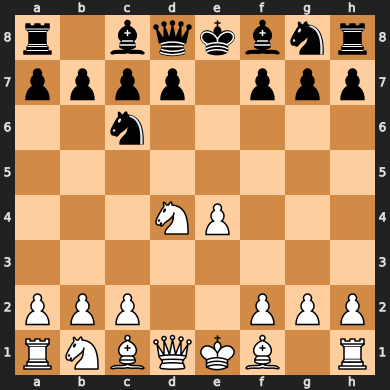

In [38]:
board